In [1]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import layers

### TF1 used to...
- `kitchen sink`: need to prepare everything before starting session

```
# params setting
    learning_rate = 0.001
    epochs = 5
    batch_size = 64
    n_input = 784
    n_classes = 10
    n_hidden_layer = 256
```

```
# weight and biases
    weights = {
        'hidden_layer': tf.Variable(tf.random.normal([n_input, n_hidden_layer])),
        'output': tf.Variable(tf.random.normal([n_hidden_layer, n_classes]))}
    biases = {
        'hidden_layer': tf.Variable(tf.random.normal([n_hidden_layer])),
        'output': tf.Variable(tf.random.normal([n_classes]))}
```

```
# input
    tf.compat.v1.disable_eager_execution()
    x = tf.compat.v1.placeholder('float32', [None, 784])
    y = tf.compat.v1.placeholder('float32', [None, n_classes])

# hidden layer with Relu
    layer_1 = tf.add(tf.matmul(x, weights['hidden_layer']), biases['hidden_layer'])
    layer_1 = tf.compat.v1.nn.relu(layer_1)
    logits = tf.add(tf.matmul(layer_1, weights['output']), biases['output'])

# loss and optimizer
    cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

```

```
# Sesssion
    init = tf.compat.v1.global_variables_initializer()

    with tf.compat.v1.Session() as sess:
        sess.run(init)
        # training
        for epoch in range(epochs):
            total_batch = int(len(train_dataset) / batch_size)
            for i in range(total_batch):
                batch_x, batch_y = train_dataset.batch(batch_size)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
```

### TF2 does this..
- `Eager execution`: no need to create graph first, just execute line by line

In [67]:
# data load
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255.
x_test = x_test.reshape(10000, 784).astype('float32') / 255.

y_train = y_train.astype('float32')
y_test =y_test.astype('float32')

#### Sequential API example
- staking layer in one direction
- only can handle models linear topology

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

In [68]:
# build model; network structure
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='relu'))  # hidden layer
model.add(layers.Dense(64, activation='relu'))  # if you want add more ..
model.add(layers.Dense(10, activation='softmax'))  # output layer

In [69]:
# compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
# fit model; train
model.fit(x_train, y_train, epochs=3, batch_size=64)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 60us/sample - loss: 1.6061 - accuracy: 0.8734
Epoch 2/3
60000/60000 [==============================] - 4s 70us/sample - loss: 1.5258 - accuracy: 0.9400
Epoch 3/3
60000/60000 [==============================] - 5s 80us/sample - loss: 1.5122 - accuracy: 0.9522


In [71]:
# evaluate
model.evaluate(x_test, y_test, batch_size=64)

10000/10000 [==============================] - 0s 46us/sample - loss: 1.5136 - accuracy: 0.9491


[1.5136361794114113, 0.9491]

### Functional API
- The Functional API is a way to create models that is more flexible than `Sequential`
- It can handle models with **non-linear topology**, models with shared layers, and models with multiple inputs or outputs.

In [50]:
# inputs
inputs = keras.Input(shape=(784,))

In [51]:
# layers, model
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

In [52]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


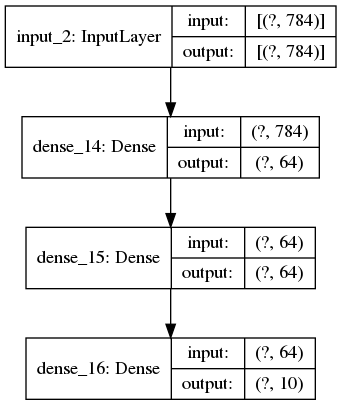

In [53]:
keras.utils.plot_model(model, 'mnist_model.png', show_shapes=True)

In [54]:
# same process before
# compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
# fit model; train
history = model.fit(x_train, y_train, epochs=3, batch_size=64)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 77us/sample - loss: 1.6573 - accuracy: 0.8183
Epoch 2/3
60000/60000 [==============================] - 5s 88us/sample - loss: 1.6059 - accuracy: 0.8574
Epoch 3/3
60000/60000 [==============================] - 4s 69us/sample - loss: 1.5688 - accuracy: 0.8948


In [57]:
history.history

{'loss': [1.657320616743962, 1.6058963883042336, 1.5687547155896822],
 'accuracy': [0.8183166666666667, 0.8574166666666667, 0.8948]}

In [59]:
test_scores = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 92us/sample - loss: 1.5142 - accuracy: 0.9516


#### Multi-input, multi-output model

In [60]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, name='class_output')(x)

# two different inputs & outputs
model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

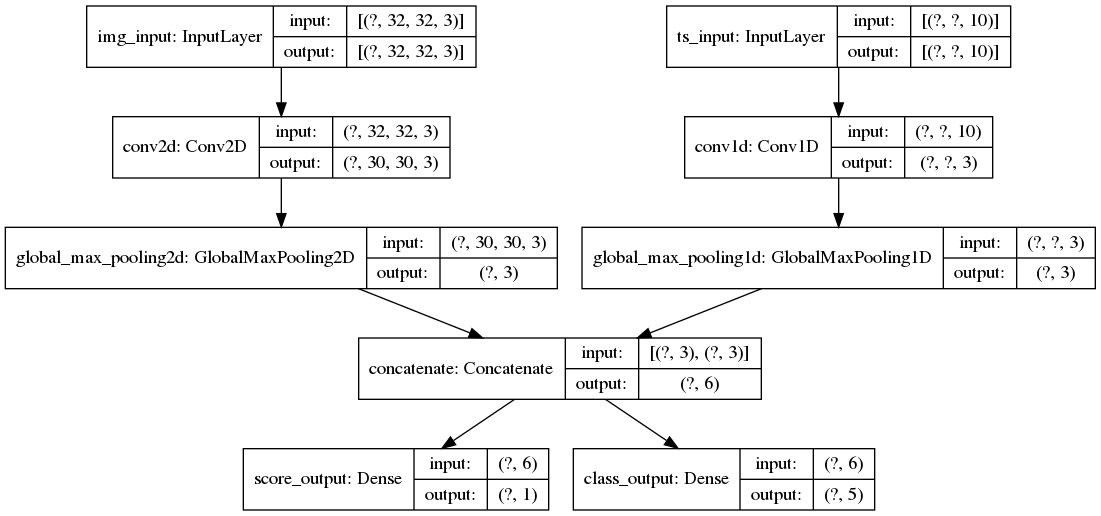

In [61]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [62]:
# two different losses & metrics for different inputs & outputs
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy(from_logits=True)],
    metrics=[[keras.metrics.MeanAbsolutePercentageError(),
              keras.metrics.MeanAbsoluteError()],
             [keras.metrics.CategoricalAccuracy()]])

#### Autoencoder

In [63]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

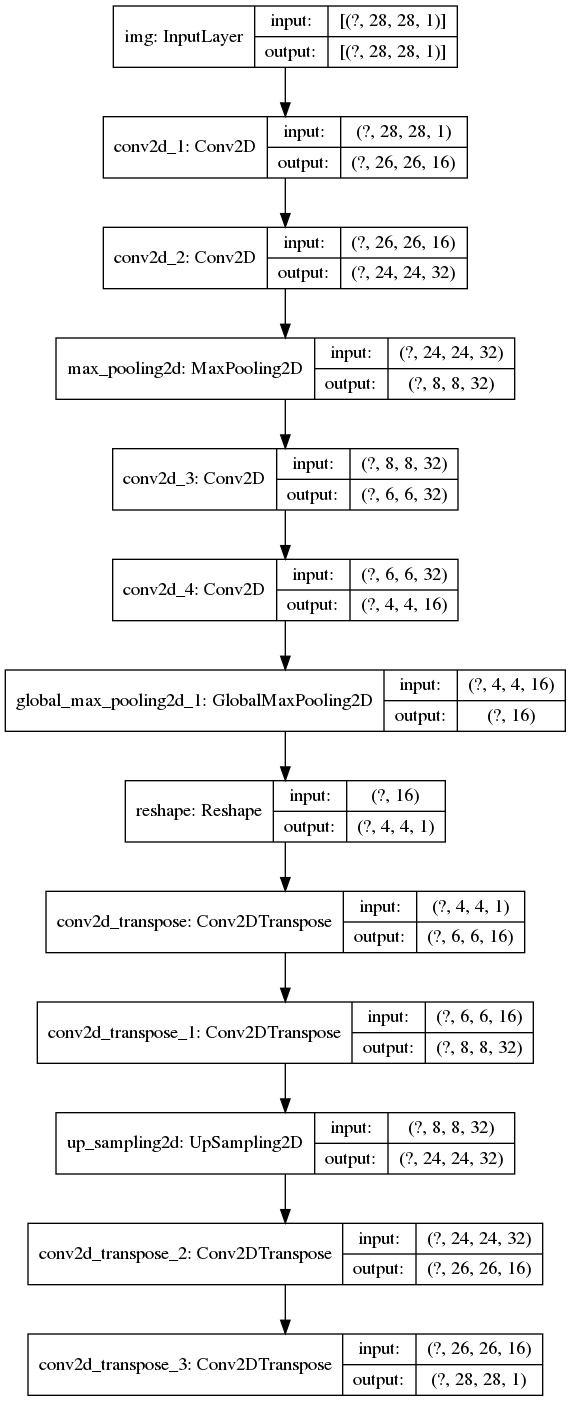

In [64]:
keras.utils.plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

![](autoencoder_structure.png)

### Extending the API by writing custom layers - Subclassing
tf.keras has a wide range of built-in layers. Here are a few examples:
- Convolutional layers: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranpose`, etc.
- Pooling layers: `MaxPooling1D`, `MaxPooling2D`, `MaxPooling3D`, `AveragePooling1D`, etc.
- RNN layers: `GRU`, `LSTM`, `ConvLSTM2D`, etc.
- `BatchNormalization`, `Dropout`, `Embedding`, etc.

If you don't find what you need, it's easy to extend the API by creating your own layers.

All layers subclass the `Layer` class and implement:
- A `call` method, that specifies the computation done by the layer.
- A `build` method, that creates the weights of the layer (note that this is just a style convention; you could create weights in `__init__` as well).

Here's a simple implementation of a `Dense` layer:

In [65]:
class CustomDense(layers.Layer):

  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

### And there're many things....